# Nikolas Iliopoulos 1115201800332
# AI_2 Part 1

# Imports & Install Tranfsormers

In [ ]:
!pip install transformers

from transformers import AutoTokenizer
from transformers import BertForSequenceClassification

import torch
from torch.utils.data import TensorDataset
from torch.optim import AdamW

import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Read the training and validation csv

In [ ]:
# reading the training csv
data = pd.read_csv('../input/vaccine/vaccine_train_set.csv')
# reading the validation csv
data_Val = pd.read_csv('../input/vaccine/vaccine_validation_set.csv')

# Define Trainer class

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

maxLength= 512
Device= cuda
GPU Model Tesla P100-PCIE-16GB


100%|██████████| 1997/1997 [15:28<00:00,  2.15it/s]


Loss:     0.6608729363103389
Accuracy: 0.7222083124687031
Precision: 0.746141384696092
Recall: 0.7222083124687031
F1 Score: 0.7057029913001364
Class 0 F1: 0.878580557852793
Class 1 F1: 0.4929116684841875
Class 2 F1: 0.8754144128424359


100%|██████████| 286/286 [00:43<00:00,  6.64it/s]


0.5941204956465668
0.7618006993006993
0.7759147102897104
0.7618006993006993
0.7451138944583006
Class 0 F1: 0.9220647773279352
Class 1 F1: 0.5088161209068011
Class 2 F1: 0.8829593693147363


100%|██████████| 1997/1997 [15:27<00:00,  2.15it/s]


Loss:     0.4612288956353641
Accuracy: 0.828242363545318
Precision: 0.860028137444264
Recall: 0.828242363545318
F1 Score: 0.8247042263222777
Class 0 F1: 0.9266748219040081
Class 1 F1: 0.782021151586369
Class 2 F1: 0.9174435206181237


100%|██████████| 286/286 [00:43<00:00,  6.63it/s]


0.6532071606106274
0.7753496503496503
0.8213890276390277
0.7753496503496503
0.7737944796074168
Class 0 F1: 0.8694267515923567
Class 1 F1: 0.7536842105263157
Class 2 F1: 0.912632821723731


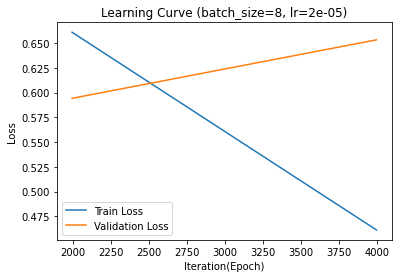

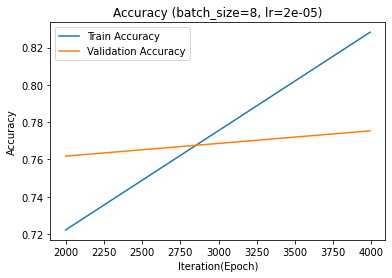

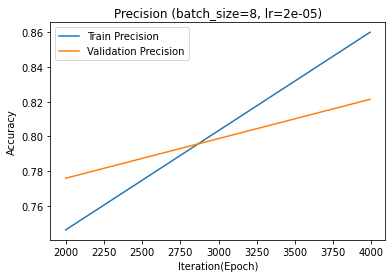

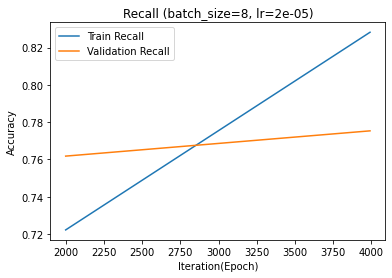

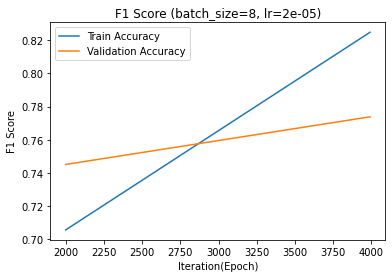

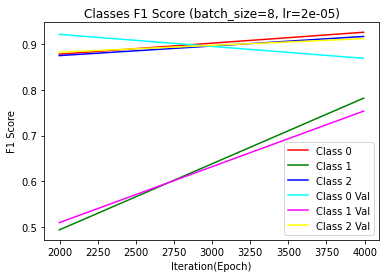

In [ ]:
class MyTrainer():
    def __init__(self, data, data_Val, lr, epochs, batchSize):
#         create the model
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True, num_labels=3)
#         create the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
#         create the optimizer
        self.optimizer = AdamW(self.model.parameters(),
                               lr=lr,
                               eps=1e-8)
#         split the tweets and labels to variables
        self.tweets = data.tweet.values
        self.tweets_val = data_Val.tweet.values

        self.labels = data.label.values
        self.labels_val = data_Val.label.values
#         define hypermarameters
        self.lr = lr
        self.epochs = epochs
        self.batchSize = batchSize
        self.maxLength = 512
        
    def prepareInputs(self):
#         lists for splitting inputs
        tokenized_text,     attention_mask,     token_type_ids     = [], [], []
        tokenized_text_val, attention_mask_val, token_type_ids_val = [], [], []

        
#         tokenize the inputs and split them
        for tweet in self.tweets:
            tokens = self.tokenizer.encode_plus(tweet,
                                                add_special_tokens = True,
                                                max_length=self.maxLength,
                                                pad_to_max_length = True,
                                                return_attention_mask = True,
                                                return_tensors = 'pt')
            tokenized_text.append(tokens['input_ids'])
            attention_mask.append(tokens['attention_mask'])
            token_type_ids.append(tokens['token_type_ids'])
        for tweet in self.tweets_val:
            tokens = self.tokenizer.encode_plus(tweet,
                                                add_special_tokens = True,
                                                max_length=self.maxLength,
                                                pad_to_max_length = True,
                                                return_attention_mask = True,
                                                return_tensors = 'pt')
            tokenized_text_val.append(tokens['input_ids'])
            attention_mask_val.append(tokens['attention_mask'])
            token_type_ids_val.append(tokens['token_type_ids'])

#         convert lists to torches
        tokenized_text = torch.cat(tokenized_text,dim=0)
        tokenized_text_val = torch.cat(tokenized_text_val,dim=0)

        attention_mask = torch.cat(attention_mask,dim=0)
        attention_mask_val = torch.cat(attention_mask_val,dim=0)

        token_type_ids = torch.cat(token_type_ids,dim=0)
        token_type_ids_val = torch.cat(token_type_ids_val,dim=0)

        labels = torch.tensor(self.labels)
        labels_val = torch.tensor(self.labels_val)

#         create the dataloaders
        self.dataloader_train = torch.utils.data.DataLoader(TensorDataset(tokenized_text,attention_mask,token_type_ids,labels), batch_size=self.batchSize, shuffle=True)
        self.dataloader_val = torch.utils.data.DataLoader(TensorDataset(tokenized_text_val,attention_mask_val,token_type_ids_val,labels_val), batch_size=self.batchSize, shuffle=True)
#         use GPU for faster computation times
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        print("maxLength=",self.maxLength)
        print("Device=",self.device)
        if self.use_cuda:
            # LOAD THE MODEL TO THE GPU
            self.model = self.model.cuda()
            print('GPU Model', torch.cuda.get_device_name(0))

    def train(self):
         totalSteps = len(self.dataloader_train)
         n_epoch=0
         self.iters = []
         self.losses, self.f1, self.precision, self.recall, self.accuracy  = [], [], [], [], []
         self.losses_Val, self.f1_Val, self.precision_Val, self.recall_Val, self.accuracy_Val = [], [], [], [], []

         self.class_f1_0, self.class_f1_1, self.class_f1_2 = [], [], []
         self.class_f1_0_Val, self.class_f1_1_Val, self.class_f1_2_Val = [], [], []

         
         for epoch in range(self.epochs):
            batch_losses, batch_f1, batch_precision, batch_recall, batch_accuracy = [], [], [], [], []
            batch_yTrueList, batch_logitsList = [], []
            batch_class_0, batch_logits_0, batch_class_1, batch_logits_1, batch_class_2, batch_logits_2 = [], [], [], [], [], []

            # -- TRAINING --
            self.model.train()
            for batch in tqdm(self.dataloader_train):
                # load the data to the GPU
                input_ids = batch[0].to(self.device)
                attention_mask = batch[1].to(self.device)
                token_type_ids = batch[2].to(self.device)
                y_batch = batch[3].to(self.device)
                
#                 predict outputs
                self.model.zero_grad()
                outputs = self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=y_batch, return_dict=True)
#                 split results
                loss = outputs.loss
                logits = outputs.logits

                # store the loss of that batch
                batch_losses.append(loss.item())
                # BackwardPropagation to calculate the gradients.
                loss.backward()
                # Clip Gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                # Update parameters
                self.optimizer.step()
                # calculate the accurancy
                logits = logits.detach().cpu().numpy()
                y_batch = y_batch.to('cpu').numpy()
                batch_accuracy.append(np.sum(np.argmax(logits, axis=1).flatten() == y_batch.flatten()) / len(y_batch.flatten()))
                batch_precision.append(precision_score(y_batch.flatten(), np.argmax(logits, axis=1).flatten(), average='weighted',zero_division=0))
                batch_recall.append(recall_score(y_batch.flatten(), np.argmax(logits, axis=1).flatten(), average='weighted',zero_division=0))
#                 calculate f1 score
                batch_f1.append(  f1_score(y_batch.flatten(), np.argmax(logits, axis=1).flatten(), average='weighted')  )
#                 store the results in order to split them later for computing the f1 for each class
                batch_yTrueList.append(y_batch.flatten())
                batch_logitsList.append(np.argmax(logits, axis=1).flatten())
                n_epoch+=1
            
#             average of scores
            self.losses.append(sum(batch_losses)/len(self.dataloader_train))
            self.accuracy.append(sum(batch_accuracy)/len(self.dataloader_train))
            self.precision.append(sum(batch_precision)/len(self.dataloader_train))
            self.recall.append(sum(batch_recall)/len(self.dataloader_train))
            self.f1.append(sum(batch_f1)/len(self.dataloader_train))
#             loop the results and split them for computing f1 for each class
            for batch, label in enumerate(batch_yTrueList):
                for pos, true in enumerate(label):
                    if true == 0:
                        batch_class_0.append(0)
                        batch_logits_0.append(batch_logitsList[batch][pos])
                    elif true == 1:
                        batch_class_1.append(1)
                        batch_logits_1.append(batch_logitsList[batch][pos])       
                    elif true == 2:
                        batch_class_2.append(2)
                        batch_logits_2.append(batch_logitsList[batch][pos])
#             store the f1 scores of each class
            self.class_f1_0.append(f1_score(batch_class_0,batch_logits_0, average='weighted'))
            self.class_f1_1.append(f1_score(batch_class_1,batch_logits_1, average='weighted'))
            self.class_f1_2.append(f1_score(batch_class_2,batch_logits_2, average='weighted'))

            self.iters.append(n_epoch)

            print("Loss:    ", sum(batch_losses)/len(self.dataloader_train))
            print("Accuracy:", sum(batch_accuracy)/len(self.dataloader_train))
            print("Precision:", sum(batch_precision)/len(self.dataloader_train))
            print("Recall:", sum(batch_recall)/len(self.dataloader_train))
            print("F1 Score:", sum(batch_f1)/len(self.dataloader_train))

            print("Class 0 F1:",f1_score(batch_class_0,batch_logits_0, average='weighted'))
            print("Class 1 F1:", f1_score(batch_class_1,batch_logits_1, average='weighted'))
            print("Class 2 F1:", f1_score(batch_class_2,batch_logits_2, average='weighted'))

            # -- VALIDATION --
            batch_losses_Val, batch_f1_Val, batch_precision_Val, batch_recall_Val, batch_accuracy_Val = [], [], [], [], []
            batch_yTrueList_Val, batch_logitsList_Val = [], []
            batch_class_0_Val, batch_logits_0_Val, batch_class_1_Val, batch_logits_1_Val, batch_class_2_Val, batch_logits_2_Val = [], [], [], [], [], []
            
            self.model.eval()
            for batch in tqdm(self.dataloader_val):  
                # load the data to the gpu
                input_ids = batch[0].to(self.device)
                attention_mask = batch[1].to(self.device)
                token_type_ids = batch[2].to(self.device)
                y_batch = batch[3].to(self.device)
#                 predict outputs
                with torch.no_grad():
                    outputs = self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=y_batch)
#                 split the results
                loss = outputs.loss
                logits = outputs.logits
                
                # store the loss of that batch
                batch_losses_Val.append(loss.item())
                # calculate the accurancy
                logits = logits.detach().cpu().numpy()
                y_batch = y_batch.to('cpu').numpy()
                batch_accuracy_Val.append(np.sum(np.argmax(logits, axis=1).flatten() == y_batch.flatten()) / len(y_batch.flatten()))
                batch_precision_Val.append(precision_score(y_batch.flatten(), np.argmax(logits, axis=1).flatten(), average='weighted',zero_division=0))
                batch_recall_Val.append(recall_score(y_batch.flatten(), np.argmax(logits, axis=1).flatten(), average='weighted',zero_division=0))
#                 calculate f1 score
                batch_f1_Val.append( f1_score(y_batch.flatten(), np.argmax(logits, axis=1).flatten(), average='weighted') )
#                 store the results in order to split them later for computing the f1 for each class
                batch_yTrueList_Val.append(y_batch.flatten())
                batch_logitsList_Val.append(np.argmax(logits, axis=1).flatten())
#             average of scores
            self.losses_Val.append(sum(batch_losses_Val)/len(self.dataloader_val))
            self.accuracy_Val.append(sum(batch_accuracy_Val)/len(self.dataloader_val))
            self.precision_Val.append(sum(batch_precision_Val)/len(self.dataloader_val))
            self.recall_Val.append(sum(batch_recall_Val)/len(self.dataloader_val))
            self.f1_Val.append(sum(batch_f1_Val)/len(self.dataloader_val))
#             loop the results and split them for computing f1 for each class
            for batch, label in enumerate(batch_yTrueList_Val):
                for pos, true in enumerate(label):
                    if true == 0:
                        batch_class_0_Val.append(0)
                        batch_logits_0_Val.append(batch_logitsList_Val[batch][pos])
                    elif true == 1:
                        batch_class_1_Val.append(1)
                        batch_logits_1_Val.append(batch_logitsList_Val[batch][pos])       
                    elif true == 2:
                        batch_class_2_Val.append(2)
                        batch_logits_2_Val.append(batch_logitsList_Val[batch][pos])
#             store the f1 scores of each class
            self.class_f1_0_Val.append(f1_score(batch_class_0_Val,batch_logits_0_Val, average='weighted'))
            self.class_f1_1_Val.append(f1_score(batch_class_1_Val,batch_logits_1_Val, average='weighted'))
            self.class_f1_2_Val.append(f1_score(batch_class_2_Val,batch_logits_2_Val, average='weighted'))

            print(sum(batch_losses_Val)/len(self.dataloader_val))
            print(sum(batch_accuracy_Val)/len(self.dataloader_val))
            print(sum(batch_precision_Val)/len(self.dataloader_val))
            print(sum(batch_recall_Val)/len(self.dataloader_val))
            print(sum(batch_f1_Val)/len(self.dataloader_val))

            print("Class 0 F1:", f1_score(batch_class_0_Val,batch_logits_0_Val, average='weighted'))
            print("Class 1 F1:", f1_score(batch_class_1_Val,batch_logits_1_Val, average='weighted'))
            print("Class 2 F1:", f1_score(batch_class_2_Val,batch_logits_2_Val, average='weighted'))
            
    def plot(self):
        plt.title("Learning Curve (batch_size={}, lr={})".format(self.batchSize, self.lr))
        plt.plot(self.iters, self.losses, label="Train Loss")
        plt.plot(self.iters, self.losses_Val, label="Validation Loss")
        plt.xlabel("Iteration(Epoch)")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()

        plt.title("Accuracy (batch_size={}, lr={})".format(self.batchSize, self.lr))
        plt.plot(self.iters, self.accuracy, label="Train Accuracy")
        plt.plot(self.iters, self.accuracy_Val, label="Validation Accuracy")
        plt.xlabel("Iteration(Epoch)")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')
        plt.show()
        
        plt.title("Precision (batch_size={}, lr={})".format(self.batchSize, self.lr))
        plt.plot(self.iters, self.precision, label="Train Precision")
        plt.plot(self.iters, self.precision_Val, label="Validation Precision")
        plt.xlabel("Iteration(Epoch)")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')
        plt.show()
        
        plt.title("Recall (batch_size={}, lr={})".format(self.batchSize, self.lr))
        plt.plot(self.iters, self.recall, label="Train Recall")
        plt.plot(self.iters, self.recall_Val, label="Validation Recall")
        plt.xlabel("Iteration(Epoch)")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')
        plt.show()

        plt.title("F1 Score (batch_size={}, lr={})".format(self.batchSize, self.lr))
        plt.plot(self.iters, self.f1, label="Train Accuracy")
        plt.plot(self.iters, self.f1_Val, label="Validation Accuracy")
        plt.xlabel("Iteration(Epoch)")
        plt.ylabel("F1 Score")
        plt.legend(loc='best')
        plt.show()

        plt.title("Classes F1 Score (batch_size={}, lr={})".format(self.batchSize, self.lr))
        plt.plot(self.iters, self.class_f1_0, color='red', label="Class 0")
        plt.plot(self.iters, self.class_f1_1, color='green', label="Class 1")
        plt.plot(self.iters, self.class_f1_2, color='blue', label="Class 2")
        plt.plot(self.iters, self.class_f1_0_Val,'-', color='cyan', label="Class 0 Val")
        plt.plot(self.iters, self.class_f1_1_Val,'-', color='magenta', label="Class 1 Val")
        plt.plot(self.iters, self.class_f1_2_Val,'-', color='yellow', label="Class 2 Val")
        plt.xlabel("Iteration(Epoch)")
        plt.ylabel("F1 Score")
        plt.legend(loc='best')
        plt.show()

# Train & Plot

In [ ]:
trainer = MyTrainer(data, data_Val, 2e-5, 2, 8)
trainer.prepareInputs()
trainer.train()
trainer.plot()